In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9563,-119.3,36.2,29.0,1735.0,323.0,805.0,293.0,3.5,89.9
2034,-117.3,34.0,17.0,1779.0,292.0,1006.0,293.0,4.7,123.1
15834,-122.4,37.8,52.0,1314.0,317.0,473.0,250.0,4.3,500.0
13593,-122.0,38.4,24.0,2434.0,630.0,1538.0,574.0,2.1,101.1
16482,-122.6,37.9,30.0,833.0,164.0,358.0,143.0,6.8,493.8
...,...,...,...,...,...,...,...,...,...
10630,-120.5,34.9,20.0,3842.0,630.0,2490.0,662.0,3.1,120.1
14134,-122.1,37.9,45.0,1544.0,244.0,614.0,238.0,5.0,226.0
5127,-118.1,34.2,36.0,1449.0,235.0,621.0,210.0,6.2,274.1
4501,-118.0,33.9,34.0,1995.0,417.0,1573.0,407.0,3.5,153.5


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [27]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[['total_rooms']]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column('total_rooms')]
#print(my_feature)
#print(feature_columns)

       total_rooms
9563        1735.0
2034        1779.0
15834       1314.0
13593       2434.0
16482        833.0
...            ...
10630       3842.0
14134       1544.0
5127        1449.0
4501        1995.0
7266        1442.0

[17000 rows x 1 columns]
[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [28]:
# Define the label.
targets = california_housing_dataframe['median_house_value']
print(targets)

9563     89.9
2034    123.1
15834   500.0
13593   101.1
16482   493.8
         ... 
10630   120.1
14134   226.0
5127    274.1
4501    153.5
7266    200.0
Name: median_house_value, Length: 17000, dtype: float64


In [29]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

In [8]:
def my_input_fn(features, targets, batch_size = 1, shuffle = True, num_epoches = None):
    """Trains a linear regression model of one feature.
    
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      num_epoches: Number of epoches for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key,value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epoches)
    
    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [30]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [31]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't
# need to repeat or shuffle the data here.
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epoches = 1, shuffle = False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn = prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [32]:
min_house_value = california_housing_dataframe['median_house_value'].min()
max_house_value = california_housing_dataframe['median_house_value'].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)


Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [33]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [34]:
sample = california_housing_dataframe.sample(n=300)

In [39]:
# Get the min and max total_rooms values.
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plat our regression line from (x_0, y_0) to (x_1, y_1)
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

# Plat a scatter plot from our data sample.
plt.scatter(sample['total_rooms'], sample['median_house_value'])

# Display graph.
plt.show()

NotFoundError: Key linear/linear_model/total_rooms not found in checkpoint

In [50]:
def train_model(learning_rate, steps, batch_size, input_feature='total_rooms'):
    """Trains a linear regression model of one feature.
    
    Args:
      learning_rate: A `float`, the learning rate.
      steps: A non-zero `int`, the total number of training steps. A training step
        consists of a forward and backward pass using a single batch.
      batch_size: A non-zero `int`, the batch size.
      input_feature: A `string` specifying a column from `california_housing_dataframe`
        to use as input feature.
    """
    
    periods = 10
    steps_per_period = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]
    
    # Create feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size = batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epoches = 1, shuffle = False)
    
    # Create a linear regresor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )
    
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically asses loss metrics.
    print("Training model...")
    print("RSME (on training data):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn = training_input_fn,
            steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        room_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets)
        )
        # Ocassionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are ploted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color = colors[period])
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data['predictions'] = pd.Series(predictions)
    calibration_data['targets'] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RSME (on training data):
  period 00 : 237.42
  period 01 : 237.42
  period 02 : 237.42
  period 03 : 237.42
  period 04 : 237.42
  period 05 : 237.42
  period 06 : 237.42
  period 07 : 237.42
  period 08 : 237.42
  period 09 : 237.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 237.42


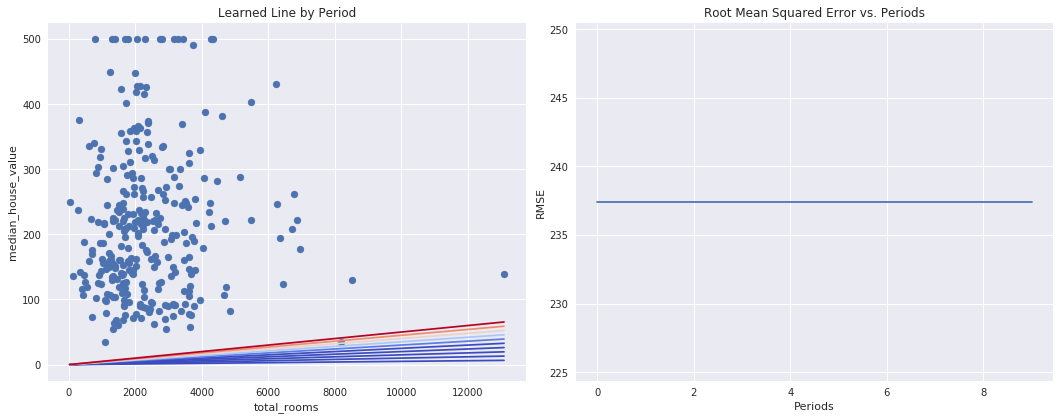

In [51]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

Training model...
RSME (on training data):
  period 00 : 237.42
  period 01 : 237.42
  period 02 : 237.42
  period 03 : 237.42
  period 04 : 237.42
  period 05 : 237.42
  period 06 : 237.42
  period 07 : 237.42
  period 08 : 237.42
  period 09 : 237.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,117.9,207.3
std,97.2,116.0
min,0.1,15.0
25%,65.2,119.4
50%,94.9,180.4
75%,140.5,265.0
max,1692.0,500.0


Final RMSE (on training data): 237.42


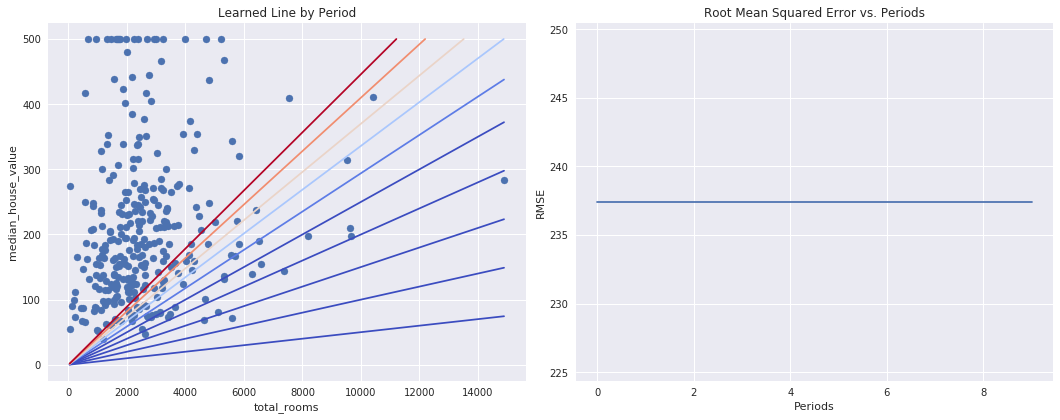

In [52]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

Training model...
RSME (on training data):
  period 00 : 237.42
  period 01 : 237.42
  period 02 : 237.42
  period 03 : 237.42
  period 04 : 237.42
  period 05 : 237.42
  period 06 : 237.42
  period 07 : 237.42
  period 08 : 237.42
  period 09 : 237.42
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,69.2,207.3
std,55.6,116.0
min,0.1,15.0
25%,38.2,119.4
50%,56.5,180.4
75%,83.3,265.0
max,1727.0,500.0


Final RMSE (on training data): 237.42


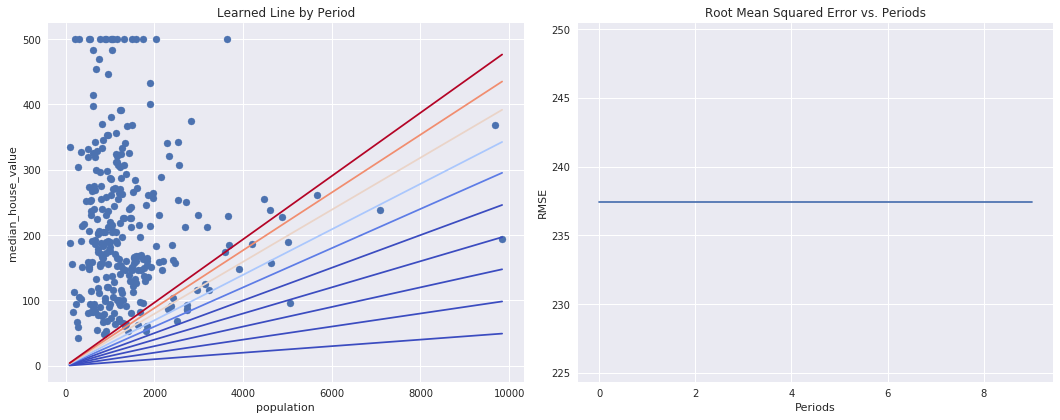

In [53]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5,
    input_feature='population'
)